# Adjoint Plugin: 3 Inverse Design Demo

In this notebook, we will use inverse design and the Tidy3D `adjoint` plugin to create an integrated photonics component to convert a fundamental waveguide mode to a higher order mode.

In [1]:
from typing import List
import numpy as np
import matplotlib.pylab as plt

# import jax to be able to use automatic differentiation
import jax.numpy as jnp
from jax import grad, value_and_grad

# import regular tidy3d 
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import ModeSolver

# import the components we need from the adjoint plugin
from tidy3d.plugins.adjoint import JaxSimulation, JaxBox, JaxCustomMedium, JaxStructure, JaxSimulationData, JaxDataArray, JaxPermittivityDataset
from tidy3d.plugins.adjoint.web import run

[16:43:26] WARNING  This version of Tidy3D was pip installed from the         ]8;id=177936;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=783037;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#104\104]8;;\
                    'tidy3d-beta' repository on PyPI. Future releases will be                
                    uploaded to the 'tidy3d' repository. From now on, please                 
                    use 'pip install tidy3d' instead.                                        

           INFO     Using client version: 1.9.0rc2                            ]8;id=103717;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=539325;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#122\122]8;;\

## Setup

We wish to recreate a device like the diagram below:

<img src="img/AdjointInvDes.png" width=800>

A mode source is injected into a waveguide on the left-hand side. The light propagates through a rectangular region filled with pixellated `Box` objects, each with a permittivity value independently tunable between 1 (vacuum) and some maximum permittivity. Finally, we measure the transmission of the light into a waveguide on the right-hand side.

The goal of the inverse design exercise is to find the permittivities ($\epsilon_{ij}$) of each `Box` in the coupling region to maximize the power conversion between the input mode and the output mode.

### Parameters

First we will define some parameters. 

In [2]:
# wavelength and frequency
wavelength = 1.0
freq0 = td.C_0 / wavelength
k0 = 2 * np.pi * freq0 / td.C_0

# resolution control
dl = 0.01

# space between boxes and PML
buffer = 0.5 * wavelength

# optimize region size
lz = td.inf
golden_ratio = 1.618
lx = 5.0
ly = lx / golden_ratio
wg_width = .7

# num cells
nx = 120
ny = int(nx / golden_ratio)
num_cells = nx * ny

# position of source and monitor (constant for all)
source_x = -lx/2 - buffer * 0.8
meas_x = lx/2 + buffer * 0.8

# total size
Lx = lx + 2 * buffer
Ly = ly + 2 * buffer
Lz = 0

# permittivity info
eps_wg = 2.75
eps_deviation_random = 0.5
eps_max = 5

# note, we choose the starting permittivities to be uniform with a small, random deviation
eps_boxes = eps_wg * np.ones((nx, ny))
eps_boxes += 2 * (np.random.random((nx, ny)) - 0.5) * eps_deviation_random
eps_boxes = eps_boxes.flatten()

# frequency width and run time
freqw = freq0 / 10
run_time = 10 / freqw

# mode in and out
mode_index_in = 0
mode_index_out = 2
num_modes = max(mode_index_in, mode_index_out) + 1
mode_spec = td.ModeSpec(num_modes=num_modes)

### Static Components

Next, we will set up the static parts of the geometry, the input source, and the output monitor using these parameters.

In [3]:
waveguide = td.Structure(
    geometry=td.Box(size=(td.inf, wg_width, lz)),
    medium=td.Medium(permittivity=eps_wg)
)

mode_size = (0,4,lz)

# source seeding the simulation
forward_source = td.ModeSource(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw),
    center=[source_x, 0, 0],
    size=mode_size,
    mode_index=mode_index_in,
    mode_spec=mode_spec,
    direction="+"
)

# we'll refer to the measurement monitor by this name often
measurement_monitor_name = 'measurement'

# monitor where we compute the objective function from
measurement_monitor = td.ModeMonitor(
    center=[meas_x, 0, 0],
    size=mode_size,
    freqs=[freq0],
    mode_spec=mode_spec,
    name=measurement_monitor_name,
)

### Input Structures

Next, we write a function to return the pixellated array given our flattened tuple of permittivity values $\epsilon_{ij}$ using [JaxCustomMedium](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc2/_autosummary/tidy3d.plugins.adjoint.JaxCustomMedium.html?highlight=JaxCustomMedium#tidy3d.plugins.adjoint.JaxCustomMedium).

We will feed the result of this function to our `JaxSimulation.input_structures` and will take the gradient w.r.t. the inputs.

In [4]:
def make_input_structures(eps_boxes) -> List[JaxStructure]:
    
    size_box_x = float(lx) / nx
    size_box_y = float(ly) / ny
    size_box = (size_box_x, size_box_y, lz)
    
    x0_min = -lx/2 + size_box_x/2
    y0_min = -ly/2 + size_box_y/2
    
    input_structures = []
    
    coords_x = [x0_min + index_x * size_box_x - 1e-5 for index_x in range(nx)]
    coords_y = [y0_min + index_y * size_box_y - 1e-5 for index_y in range(ny)]

    coords = dict(x=coords_x, y=coords_y, z=[0], f=[freq0])
    values = []
    
    index_box = 0
    for index_x in range(nx):
        x0 = coords_x[index_x]
        for index_y in range(ny):
            y0 = coords_y[index_y]
            values.append(eps_boxes[index_box])
            index_box += 1

    
    values = jnp.array(values).reshape((nx, ny, 1, 1))
    field_components = {f"eps_{dim}{dim}": JaxDataArray(values=values, coords=coords) for dim in "xyz"}
    eps_dataset = JaxPermittivityDataset(**field_components)
    custom_medium = JaxCustomMedium(eps_dataset=eps_dataset)
    box = JaxBox(center=(0,0,0), size=(lx, ly, lz))
    custom_structure = JaxStructure(geometry=box, medium=custom_medium)
    return [custom_structure]

### Jax Simulation
Next, we write a function to return the `JaxSimulation` as a function of our $\epsilon_{ij}$ values.

We make sure to add the pixellated `JaxStructure` list to `input_structures` and the `measurement_monitor` to `output_monitors`.

In [5]:
def make_sim(eps_boxes) -> JaxSimulation:
    
    input_structures = make_input_structures(eps_boxes)

    return JaxSimulation(
        size=[Lx, Ly, Lz],
        grid_spec=td.GridSpec.uniform(dl=dl),
        structures=[waveguide],
        input_structures=input_structures,
        sources=[forward_source],
        monitors=[],
        output_monitors=[measurement_monitor],
        run_time=run_time,
        subpixel=True,
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
        shutoff=1e-8,
        courant=0.9,
    )

### Visualize
Let's visualize the simulation to see how it looks

           INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND:   ]8;id=363979;file:///home/momchil/miniconda3/envs/flex/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=373642;file:///home/momchil/miniconda3/envs/flex/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py#333\333]8;;\
                    Unable to find driver in registry given worker:                          

           INFO     Unable to initialize backend 'cuda': module             ]8;id=442503;file:///home/momchil/miniconda3/envs/flex/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=867358;file:///home/momchil/miniconda3/envs/flex/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py#333\333]8;;\
                    'jaxlib.xla_extension' has no attribute                                  
                    'GpuAllocatorConfig'                                                     

           INFO     Unable to initialize backend 'rocm': module             ]8;id=344084;file:///home/momchil/miniconda3/envs/flex/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=225380;file:///home/momchil/miniconda3/envs/flex/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py#333\333]8;;\
                    'jaxlib.xla_extension' has no attribute                                  
                    'GpuAllocatorConfig'                                                     

           INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT:   ]8;id=596136;file:///home/momchil/miniconda3/envs/flex/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=925085;file:///home/momchil/miniconda3/envs/flex/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py#333\333]8;;\
                    TpuPlatform is not available.                                            

           WARNING  No GPU/TPU found, falling back to CPU. (Set             ]8;id=26659;file:///home/momchil/miniconda3/envs/flex/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=475553;file:///home/momchil/miniconda3/envs/flex/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py#340\340]8;;\
                    TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)                         

           WARNING  'BoundarySpec.z' uses default value, which is             ]8;id=968671;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=939348;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py#607\607]8;;\
                    'Periodic()' but will change to 'PML()' in Tidy3D version                
                    2.0. We recommend explicitly setting all boundary                        
                    conditions ahead of this release to avoid unexpected                     
                    results.                                                                 

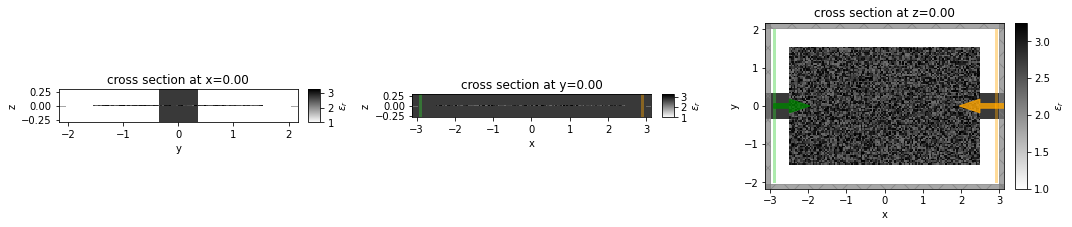

In [6]:
sim_start = make_sim(eps_boxes)

f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(15, 10))

for dim, ax in zip('xyz', axes):
    sim_start.plot_eps(**{dim:0}, ax=ax)

plt.show()

### Select Input and Output Modes

Next, let's visualize the mode profiles so we can inspect which mode indices we want to inject and transmit.

Effective index of computed modes:  [[1.5736597 1.5368265 1.3096672]]


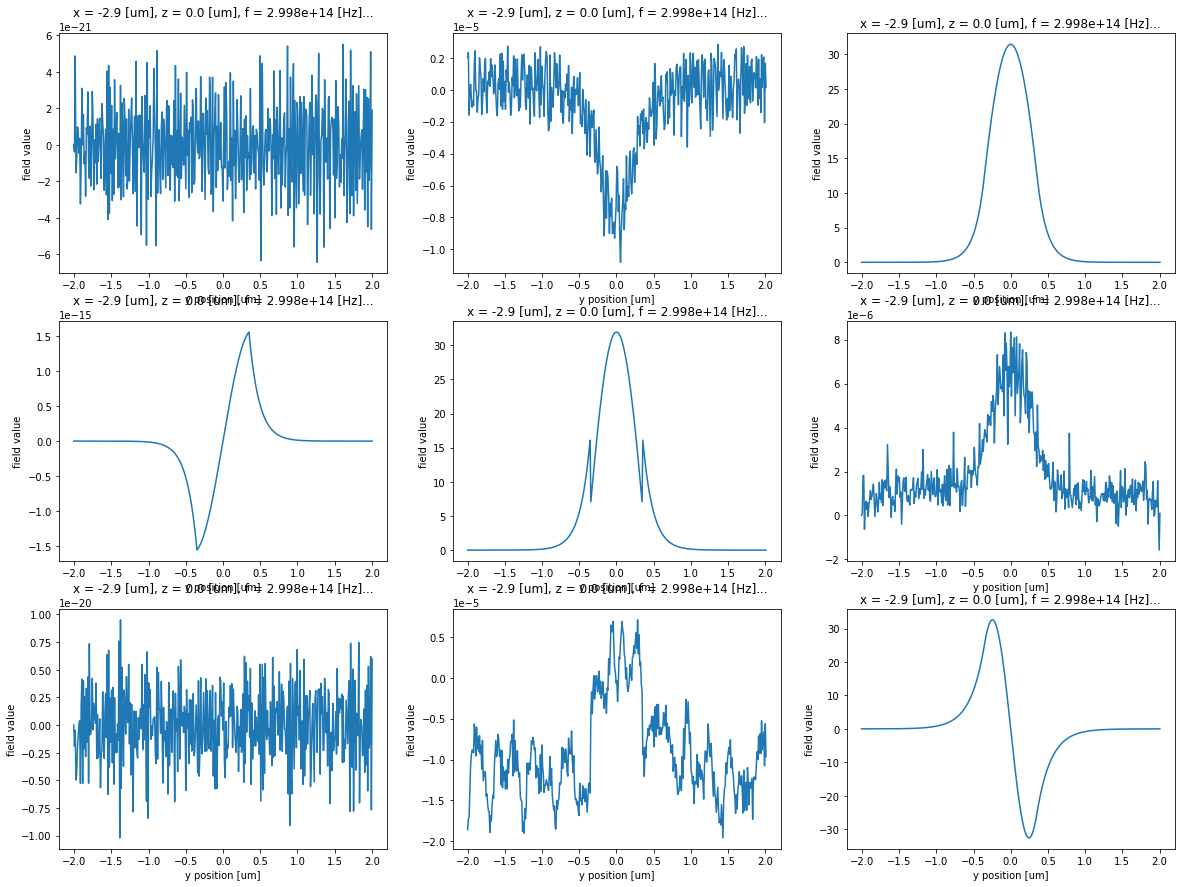

In [7]:
mode_solver = ModeSolver(simulation=sim_start, plane=forward_source, mode_spec=mode_spec, freqs=[freq0])
modes = mode_solver.solve()

print("Effective index of computed modes: ", np.array(modes.n_eff))

fig, axs = plt.subplots(num_modes, 3, figsize=(20, 15))
for mode_ind in range(num_modes):
    for field_ind, field_name in enumerate(('Ex', 'Ey', 'Ez')):
        field = modes.field_components[field_name].sel(mode_index=mode_ind)
        ax = axs[mode_ind, field_ind]
        field.real.plot(ax=ax)

Aftert inspection, we decide to inject the fundamental, Ez-polarized input into the 1st order Ez-polarized input.

From the plots, we see that these modes correspond to the first and third rows, or `mode_index=0` and `mode_index=2`, respectively. 

So we make sure that the `mode_index_in` and `mode_index_out` variables are set appropriately.

### Post Processing

We will define one more function to tell us how we want to postprocess a `JaxSimulationData` object to give the conversion power that we are interested in maximizing.

In [8]:
def measure_power(sim_data: JaxSimulationData) -> float:
    """Return the power in the output_data amplitude at the mode index of interest."""
    output_amps = sim_data.output_data[0].amps
    amp = output_amps.sel(direction="+", f=freq0, mode_index=mode_index_out)
    return jnp.sum(jnp.abs(amp)**2)

penalty_strength = 0.0
def binary_penalty(eps_boxes, penalty_strength=0.0):
    """Applies penalty of `penalty_strength` directly between 1 and eps_max and 0 at the boundaries."""

    delta_eps = eps_max - 1
    eps_average = jnp.mean(eps_boxes)
    above_vacuum = eps_average - 1
    below_epsmax = eps_max - eps_average
    return penalty_strength * above_vacuum * below_epsmax / delta_eps
    

### Define Objective Function

Finally, we need to define the objective function that we want to maximize as a function of our input parameters (permittivity of each box) that returns the conversion power. This is the function we will differentiate later.

In [9]:
def J(eps_boxes, step_num:int=None) -> float:
    sim = make_sim(eps_boxes)
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = run(sim, task_name=task_name)
    power = measure_power(sim_data)
    penalty = binary_penalty(eps_boxes)
    return power - penalty

## Inverse Design

Now we are ready to perform the optimization.

We use the `jax.value_and_grad` function to get the gradient of `J` with respect to the permittivity of each `Box`, while also returning the converted power associated with the current iteration, so we can record this value for later.

Let's try running this function once to make sure it works.

In [10]:
dJ_fn = value_and_grad(J)

In [11]:
val, grad = dJ_fn(eps_boxes)
print(grad.shape)

[16:43:40] WARNING  'BoundarySpec.z' uses default value, which is             ]8;id=574259;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=486851;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py#607\607]8;;\
                    'Periodic()' but will change to 'PML()' in Tidy3D version                
                    2.0. We recommend explicitly setting all boundary                        
                    conditions ahead of this release to avoid unexpected                     
                    results.                                                                 

[16:43:42] INFO     Using Tidy3D credentials from stored file.                     ]8;id=801544;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=736521;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#77\77]8;;\

[16:43:44] INFO     Authentication successful.                                     ]8;id=206263;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=907109;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#37\37]8;;\

           INFO     Created task 'inv_des_fwd' with task_id                     ]8;id=259998;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=561910;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '5e0ae85f-661c-4110-ac89-043667749999'.                                  

Output()

Output()

[16:43:45] INFO     status = queued                                             ]8;id=539094;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=232763;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:43:48] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=2114;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=539581;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:43:50] INFO     status = preprocess                                         ]8;id=557550;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=820983;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:43:54] INFO     starting up solver                                          ]8;id=892095;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=954453;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:44:02] INFO     running solver                                              ]8;id=807452;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=286671;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:44:03] INFO     status = postprocess                                        ]8;id=764550;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=683383;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:44:10] INFO     status = success                                            ]8;id=637479;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=61404;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=610243;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=380289;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

[16:44:11] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=406128;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=381921;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

           INFO     loading SimulationData from simulation_data.hdf5            ]8;id=821749;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=676986;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 3.35e-06 is greater   ]8;id=687743;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=630052;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

[16:44:13] INFO     Created task 'inv_des_adj' with task_id                     ]8;id=633990;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=883007;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'bb78bbfa-6e52-4bad-b7b6-5eb4c7e6a47e'.                                  

Output()

Output()

[16:44:14] INFO     status = queued                                             ]8;id=831661;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=82184;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:44:17] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=874826;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=840014;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:44:19] INFO     status = preprocess                                         ]8;id=334530;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=435957;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:44:23] INFO     starting up solver                                          ]8;id=205040;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=630355;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:44:30] INFO     running solver                                              ]8;id=748910;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=699446;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:44:31] INFO     status = postprocess                                        ]8;id=104104;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=705334;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:44:38] INFO     status = success                                            ]8;id=954458;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=428166;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=170665;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=196435;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=777990;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=348452;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:44:39] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=174163;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=110265;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 2.78e-05 is greater   ]8;id=292403;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=771176;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

(8880,)


### Optimization

We will use "Adam" optimization strategy to perform sequential updates of each of the permittivity values in the [JaxCustomMedium](https://docs.flexcompute.com/projects/tidy3d/en/v1.9.0rc2/_autosummary/tidy3d.plugins.adjoint.JaxCustomMedium.html?highlight=JaxCustomMedium#tidy3d.plugins.adjoint.JaxCustomMedium).

For more information on what we use to implement this method, see [this article](https://optimization.cbe.cornell.edu/index.php?title=Adam).

We will run 10 steps and measure both the permittivities and powers at each iteration.

We capture this process in an `optimize` function, which accepts various parameters that we can tweak.

In [12]:
permittivities = np.array(eps_boxes)

Js = []
perms = [permittivities]

def optimize(
    permittivities,
    step_size=.2,
    num_steps=8,
    eps_max=eps_max,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
):

    mt = np.zeros_like(permittivities)
    vt = np.zeros_like(permittivities)

    for i in range(num_steps):

        t = i + 1
        print(f'step = {t}')

        power, gradient = dJ_fn(permittivities, step_num=t)
        gradient = np.array(gradient).copy()

        mt = beta1 * mt + (1-beta1) * gradient
        vt = beta2 * vt + (1-beta2) * gradient**2

        mt_hat = mt / (1 - beta1**t)
        vt_hat = vt / (1 - beta2**t)

        update = step_size * (mt_hat / np.sqrt(vt_hat) + epsilon)

        Js.append(power)
        print(f'\tJ = {power:.4e}')
        print(f'\tgrad_norm = {np.linalg.norm(gradient):.4e}')

        permittivities += update
        permittivities[permittivities > eps_max] = eps_max
        permittivities[permittivities < 1.0] = 1.0
        perms.append(permittivities.copy())
    return permittivities

Let's run the optimize function.

In [13]:
perms_after = optimize(permittivities)

step = 1


[16:45:00] WARNING  'BoundarySpec.z' uses default value, which is             ]8;id=277601;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=132924;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py#607\607]8;;\
                    'Periodic()' but will change to 'PML()' in Tidy3D version                
                    2.0. We recommend explicitly setting all boundary                        
                    conditions ahead of this release to avoid unexpected                     
                    results.                                                                 

           INFO     Created task 'inv_des_step_1_fwd' with task_id              ]8;id=537224;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=990964;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '5b902fd1-95e5-4010-afcd-d59dc1e64cb2'.                                  

Output()

Output()

[16:45:02] INFO     status = queued                                             ]8;id=617578;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=300964;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:45:05] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=816852;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=160928;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:45:07] INFO     status = preprocess                                         ]8;id=198658;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=32867;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:45:10] INFO     starting up solver                                          ]8;id=531133;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=956219;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:45:18] INFO     running solver                                              ]8;id=730695;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=8484;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:45:19] INFO     status = postprocess                                        ]8;id=718584;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=50110;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:45:26] INFO     status = success                                            ]8;id=714442;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=659705;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:45:27] INFO     Billed FlexUnit cost: 0.000                                 ]8;id=682631;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=103351;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=452320;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=830986;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

           INFO     loading SimulationData from simulation_data.hdf5            ]8;id=597467;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=342181;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 3.35e-06 is greater   ]8;id=248267;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=106930;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

[16:45:29] INFO     Created task 'inv_des_step_1_adj' with task_id              ]8;id=926528;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=911334;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '9f59b0ed-6e9e-42ce-9baa-831a6cead189'.                                  

Output()

Output()

[16:45:30] INFO     status = queued                                             ]8;id=652803;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=853078;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:45:33] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=634761;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=776175;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:45:35] INFO     status = preprocess                                         ]8;id=29242;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=826049;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:45:38] INFO     starting up solver                                          ]8;id=420314;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=142120;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:45:46] INFO     running solver                                              ]8;id=64824;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=822340;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:45:47] INFO     status = postprocess                                        ]8;id=120844;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=283605;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:45:53] INFO     status = success                                            ]8;id=928036;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=903956;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=787860;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=783432;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=754469;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=681681;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:45:55] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=563522;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=132689;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 2.78e-05 is greater   ]8;id=255574;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=717986;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

	J = 1.0439e-03
	grad_norm = 2.6659e-02
step = 2


[16:46:12] WARNING  'BoundarySpec.z' uses default value, which is             ]8;id=974716;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=819115;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py#607\607]8;;\
                    'Periodic()' but will change to 'PML()' in Tidy3D version                
                    2.0. We recommend explicitly setting all boundary                        
                    conditions ahead of this release to avoid unexpected                     
                    results.                                                                 

[16:46:13] INFO     Created task 'inv_des_step_2_fwd' with task_id              ]8;id=838658;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=739344;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '6797f5cd-c1f3-4fe4-b2aa-13d486feffce'.                                  

Output()

Output()

[16:46:14] INFO     status = queued                                             ]8;id=444847;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=21135;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:46:21] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=219274;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=244020;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:46:23] INFO     status = preprocess                                         ]8;id=800840;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=284627;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:46:26] INFO     starting up solver                                          ]8;id=894441;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=360919;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:46:34] INFO     running solver                                              ]8;id=391021;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=515965;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:46:35] INFO     status = postprocess                                        ]8;id=220061;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=43373;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:46:42] INFO     status = success                                            ]8;id=138688;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=484442;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=308637;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=723248;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=527296;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=558112;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:46:43] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=683556;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=964460;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 4.37e-06 is greater   ]8;id=520804;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=463967;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

[16:46:44] INFO     Created task 'inv_des_step_2_adj' with task_id              ]8;id=558658;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=6402;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '33cc21a8-41e8-41a9-bd86-999b1370ea7b'.                                  

Output()

Output()

[16:46:46] INFO     status = queued                                             ]8;id=323638;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=481649;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:46:49] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=884385;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=53698;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:46:51] INFO     status = preprocess                                         ]8;id=472787;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=145317;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:46:54] INFO     starting up solver                                          ]8;id=339993;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=113731;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:47:02] INFO     running solver                                              ]8;id=115337;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=121343;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:47:03] INFO     status = postprocess                                        ]8;id=881077;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=394186;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:47:09] INFO     status = success                                            ]8;id=416504;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=664323;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:47:10] INFO     Billed FlexUnit cost: 0.000                                 ]8;id=599336;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=444149;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=505796;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=822796;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:47:11] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=424502;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=336735;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 6.38e-06 is greater   ]8;id=782715;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=442426;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

	J = 5.1856e-01
	grad_norm = 2.6509e-01
step = 3


[16:47:27] WARNING  'BoundarySpec.z' uses default value, which is             ]8;id=129137;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=938786;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py#607\607]8;;\
                    'Periodic()' but will change to 'PML()' in Tidy3D version                
                    2.0. We recommend explicitly setting all boundary                        
                    conditions ahead of this release to avoid unexpected                     
                    results.                                                                 

[16:47:28] INFO     Created task 'inv_des_step_3_fwd' with task_id              ]8;id=309176;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=797523;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'fcf85337-817c-44a2-9f6a-c9babaa8a7f8'.                                  

Output()

Output()

[16:47:29] INFO     status = queued                                             ]8;id=442011;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=801435;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:47:32] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=647376;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=680796;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:47:34] INFO     status = preprocess                                         ]8;id=339730;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=136277;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:47:38] INFO     starting up solver                                          ]8;id=662347;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=809983;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:47:45] INFO     running solver                                              ]8;id=492736;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=593668;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:47:46] INFO     status = postprocess                                        ]8;id=513263;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=926853;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:47:54] INFO     status = success                                            ]8;id=621492;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=140523;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=444589;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=434510;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=768582;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=812162;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:47:55] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=935895;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=619499;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 1.7e-06 is greater    ]8;id=669566;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=797577;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

[16:47:56] INFO     Created task 'inv_des_step_3_adj' with task_id              ]8;id=213128;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=201135;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '85939702-a916-41dd-b4d7-e9b411380c36'.                                  

Output()

Output()

[16:47:58] INFO     status = queued                                             ]8;id=985337;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=672379;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:48:00] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=513659;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=928425;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:48:02] INFO     status = preprocess                                         ]8;id=410848;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=502066;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:48:06] INFO     starting up solver                                          ]8;id=862639;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=120963;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:48:13] INFO     running solver                                              ]8;id=224280;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=362238;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:48:14] INFO     status = postprocess                                        ]8;id=549987;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=600352;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:48:21] INFO     status = success                                            ]8;id=192479;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=46386;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=906167;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=976902;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=19259;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=44866;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:48:22] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=657750;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=955517;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 3.06e-06 is greater   ]8;id=45575;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=275901;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

	J = 7.3505e-01
	grad_norm = 8.6448e-01
step = 4


[16:48:38] WARNING  'BoundarySpec.z' uses default value, which is             ]8;id=155823;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=324547;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py#607\607]8;;\
                    'Periodic()' but will change to 'PML()' in Tidy3D version                
                    2.0. We recommend explicitly setting all boundary                        
                    conditions ahead of this release to avoid unexpected                     
                    results.                                                                 

[16:48:39] INFO     Created task 'inv_des_step_4_fwd' with task_id              ]8;id=741956;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=929795;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'ee224ab8-b3f7-466a-bbd1-f14115c4d1f6'.                                  

Output()

Output()

[16:48:40] INFO     status = queued                                             ]8;id=806192;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=642419;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:48:47] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=125377;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=133362;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:48:49] INFO     status = preprocess                                         ]8;id=330652;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=734822;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:48:52] INFO     starting up solver                                          ]8;id=854528;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=834309;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:49:00] INFO     running solver                                              ]8;id=760145;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=65142;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:49:01] INFO     status = postprocess                                        ]8;id=902801;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=150650;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:49:08] INFO     status = success                                            ]8;id=92039;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=261845;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=996775;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=908909;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=427779;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=714517;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:49:09] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=557804;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=829982;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 2.88e-07 is greater   ]8;id=804756;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=3302;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

[16:49:10] INFO     Created task 'inv_des_step_4_adj' with task_id              ]8;id=367713;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=646093;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '2613097c-35ee-4d24-97d9-697fc0a948e7'.                                  

Output()

Output()

[16:49:11] INFO     status = queued                                             ]8;id=513117;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=165713;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:49:16] INFO     status = preprocess                                         ]8;id=871267;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=963885;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:49:19] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=834043;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=306309;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

           INFO     starting up solver                                          ]8;id=360303;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=338548;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:49:27] INFO     running solver                                              ]8;id=266910;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=274375;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:49:28] INFO     status = postprocess                                        ]8;id=215264;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=699444;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:49:35] INFO     status = success                                            ]8;id=752664;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=560466;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=900931;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=82363;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

[16:49:36] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=742604;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=313731;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:49:37] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=461075;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=402157;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 6.83e-07 is greater   ]8;id=3795;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=625309;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

	J = 8.6173e-01
	grad_norm = 4.1737e-01
step = 5


[16:49:53] WARNING  'BoundarySpec.z' uses default value, which is             ]8;id=153553;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=261157;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py#607\607]8;;\
                    'Periodic()' but will change to 'PML()' in Tidy3D version                
                    2.0. We recommend explicitly setting all boundary                        
                    conditions ahead of this release to avoid unexpected                     
                    results.                                                                 

[16:49:54] INFO     Created task 'inv_des_step_5_fwd' with task_id              ]8;id=710332;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=164881;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'c36e672c-5ac9-42a7-bd55-b499733ac32e'.                                  

Output()

Output()

[16:49:55] INFO     status = queued                                             ]8;id=629706;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=552374;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:49:58] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=881887;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=223302;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:50:00] INFO     status = preprocess                                         ]8;id=958765;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=87464;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:50:04] INFO     starting up solver                                          ]8;id=259475;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=393658;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:50:11] INFO     running solver                                              ]8;id=872167;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=612716;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:50:12] INFO     status = postprocess                                        ]8;id=426384;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=390579;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:50:23] INFO     status = success                                            ]8;id=537612;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=572180;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=673555;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=662482;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=844520;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=674595;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:50:24] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=534222;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=296262;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 2.1e-07 is greater    ]8;id=315189;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=743847;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

[16:50:25] INFO     Created task 'inv_des_step_5_adj' with task_id              ]8;id=944435;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=815230;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '38ae39e8-96f6-4b63-9cc0-4a29c55da867'.                                  

Output()

Output()

[16:50:27] INFO     status = queued                                             ]8;id=650350;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=383261;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:50:30] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=712347;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=734472;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:50:31] INFO     status = preprocess                                         ]8;id=164697;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=33359;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:50:35] INFO     starting up solver                                          ]8;id=637124;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=936278;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:50:42] INFO     running solver                                              ]8;id=451463;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=359542;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:50:43] INFO     status = postprocess                                        ]8;id=945820;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=951583;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:50:50] INFO     status = success                                            ]8;id=233090;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=467020;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=465665;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=881652;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=189765;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=910632;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:50:51] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=115323;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=127460;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 8.32e-07 is greater   ]8;id=344337;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=181644;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

	J = 8.8717e-01
	grad_norm = 4.0637e-01
step = 6


[16:51:07] WARNING  'BoundarySpec.z' uses default value, which is             ]8;id=327522;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=940008;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py#607\607]8;;\
                    'Periodic()' but will change to 'PML()' in Tidy3D version                
                    2.0. We recommend explicitly setting all boundary                        
                    conditions ahead of this release to avoid unexpected                     
                    results.                                                                 

[16:51:08] INFO     Created task 'inv_des_step_6_fwd' with task_id              ]8;id=286370;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=192559;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '9bff7717-7881-403d-a848-757091bf852d'.                                  

Output()

Output()

[16:51:09] INFO     status = queued                                             ]8;id=243248;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=263282;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:51:14] INFO     status = preprocess                                         ]8;id=858879;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=542594;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:51:17] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=520170;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=166170;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:51:18] INFO     starting up solver                                          ]8;id=304769;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=863464;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:51:25] INFO     running solver                                              ]8;id=813829;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=834346;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:51:27] INFO     status = postprocess                                        ]8;id=863585;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=184041;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:51:34] INFO     status = success                                            ]8;id=231667;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=196191;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:51:35] INFO     Billed FlexUnit cost: 0.000                                 ]8;id=606792;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=9860;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=352174;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=917362;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:51:36] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=23300;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=23562;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 2.67e-07 is greater   ]8;id=550889;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=167127;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

[16:51:37] INFO     Created task 'inv_des_step_6_adj' with task_id              ]8;id=260263;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=860622;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '15c69f9a-067b-4e72-a896-7a7f8e1e7922'.                                  

Output()

Output()

[16:51:38] INFO     status = queued                                             ]8;id=367739;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=313182;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:51:41] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=222687;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=532385;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:51:43] INFO     status = preprocess                                         ]8;id=768082;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=947606;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:51:46] INFO     starting up solver                                          ]8;id=982481;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=423022;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:51:54] INFO     running solver                                              ]8;id=837869;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=476965;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:51:55] INFO     status = postprocess                                        ]8;id=941891;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=801715;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:52:02] INFO     status = success                                            ]8;id=874671;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=3104;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=91740;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=660208;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=196731;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=2293;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:52:03] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=710517;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=153711;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 1.01e-06 is greater   ]8;id=362717;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=16783;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

	J = 9.1050e-01
	grad_norm = 4.6145e-01
step = 7


[16:52:19] WARNING  'BoundarySpec.z' uses default value, which is             ]8;id=588367;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=760207;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py#607\607]8;;\
                    'Periodic()' but will change to 'PML()' in Tidy3D version                
                    2.0. We recommend explicitly setting all boundary                        
                    conditions ahead of this release to avoid unexpected                     
                    results.                                                                 

[16:52:20] INFO     Created task 'inv_des_step_7_fwd' with task_id              ]8;id=409993;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=933419;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'd8739eac-bf12-4288-b7dd-0d3c22faa6b8'.                                  

Output()

Output()

[16:52:21] INFO     status = queued                                             ]8;id=166208;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=292199;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:52:24] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=148074;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=365117;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:52:26] INFO     status = preprocess                                         ]8;id=604195;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=112874;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:52:30] INFO     starting up solver                                          ]8;id=668582;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=111000;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:52:41] INFO     running solver                                              ]8;id=166237;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=460919;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

[16:52:42] INFO     status = postprocess                                        ]8;id=370513;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=38280;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

Output()

[16:52:46] INFO     status = success                                            ]8;id=858976;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=114515;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=204946;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=295026;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=248395;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=27509;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:52:47] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=32274;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=623318;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 4.6e-07 is greater    ]8;id=815060;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=366122;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

[16:52:48] INFO     Created task 'inv_des_step_7_adj' with task_id              ]8;id=971304;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=164641;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '875681b2-74d2-4e8a-945d-c115bad77840'.                                  

Output()

Output()

[16:52:50] INFO     status = queued                                             ]8;id=786324;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=153568;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:52:52] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=334875;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=526633;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:52:54] INFO     status = preprocess                                         ]8;id=36250;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=935446;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:52:57] INFO     starting up solver                                          ]8;id=992978;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=705032;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:53:05] INFO     running solver                                              ]8;id=308864;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=832496;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:53:06] INFO     status = postprocess                                        ]8;id=555640;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=477381;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:53:12] INFO     status = success                                            ]8;id=687914;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=192386;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:53:13] INFO     Billed FlexUnit cost: 0.000                                 ]8;id=912001;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=231673;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=771807;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=9008;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

           INFO     loading SimulationData from simulation_data.hdf5            ]8;id=497782;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=43693;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 1.22e-06 is greater   ]8;id=750042;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=867450;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

	J = 9.2844e-01
	grad_norm = 3.3527e-01
step = 8


[16:53:30] WARNING  'BoundarySpec.z' uses default value, which is             ]8;id=963498;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=56691;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py#607\607]8;;\
                    'Periodic()' but will change to 'PML()' in Tidy3D version                
                    2.0. We recommend explicitly setting all boundary                        
                    conditions ahead of this release to avoid unexpected                     
                    results.                                                                 

           INFO     Created task 'inv_des_step_8_fwd' with task_id              ]8;id=995571;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=129418;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '364cbc29-4c54-4f27-bd65-d827bee3ed8c'.                                  

Output()

Output()

[16:53:32] INFO     status = queued                                             ]8;id=598800;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=353676;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:53:35] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=948799;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=111979;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:53:37] INFO     status = preprocess                                         ]8;id=848313;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=265504;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:53:40] INFO     starting up solver                                          ]8;id=823039;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=558145;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:53:48] INFO     running solver                                              ]8;id=666366;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=127821;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:53:49] INFO     status = postprocess                                        ]8;id=286564;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=535343;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:53:56] INFO     status = success                                            ]8;id=528305;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=152439;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=514039;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=154897;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=69658;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=954290;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:53:57] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=523937;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=348575;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 6.61e-07 is greater   ]8;id=113966;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=149457;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

[16:53:58] INFO     Created task 'inv_des_step_8_adj' with task_id              ]8;id=999934;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=545886;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'd3997369-18cc-472d-8712-be4e3c0a406a'.                                  

Output()

Output()

[16:53:59] INFO     status = queued                                             ]8;id=208862;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=71725;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:54:03] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=32533;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=646400;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:54:05] INFO     status = preprocess                                         ]8;id=31861;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=930696;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:54:08] INFO     starting up solver                                          ]8;id=103618;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=933982;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:54:15] INFO     running solver                                              ]8;id=55361;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=839918;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:54:17] INFO     status = postprocess                                        ]8;id=470543;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=568679;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:54:23] INFO     status = success                                            ]8;id=909600;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=517007;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=648817;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=773580;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=810891;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=765588;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:54:24] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=162975;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=209974;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 2.07e-06 is greater   ]8;id=511790;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=748275;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

	J = 9.3775e-01
	grad_norm = 1.1264e-01


and then record the final power value (including the last iteration's parameter updates).

In [14]:
power = J(perms_after)
Js.append(power)

[16:54:34] WARNING  'BoundarySpec.z' uses default value, which is             ]8;id=234250;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=115424;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py#607\607]8;;\
                    'Periodic()' but will change to 'PML()' in Tidy3D version                
                    2.0. We recommend explicitly setting all boundary                        
                    conditions ahead of this release to avoid unexpected                     
                    results.                                                                 

[16:54:35] INFO     Created task 'inv_des' with task_id                         ]8;id=963229;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=200807;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'd8202d4d-b917-4aa8-a3ef-15a2d1aa9309'.                                  

Output()

Output()

[16:54:36] INFO     status = queued                                             ]8;id=215045;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=589914;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:54:39] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=871939;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=286448;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:54:41] INFO     status = preprocess                                         ]8;id=845216;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=8070;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:54:44] INFO     starting up solver                                          ]8;id=538212;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=648854;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:54:52] INFO     running solver                                              ]8;id=648085;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=190598;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:54:53] INFO     status = postprocess                                        ]8;id=716517;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=236969;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:54:57] INFO     status = success                                            ]8;id=211176;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=654946;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                 ]8;id=678004;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=659200;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

[16:54:58] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=20625;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=151679;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

           INFO     loading SimulationData from simulation_data.hdf5            ]8;id=497121;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=376275;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 9.25e-07 is greater   ]8;id=129555;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=891935;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

### Results

First, we plot the objective function (power converted to 1st order mode) as a function of step and notice that it converges nicely!

The final device converts about 90% of the input power to the 1st mode, up from < 1% when we started, with room for improvement if we run with more steps.

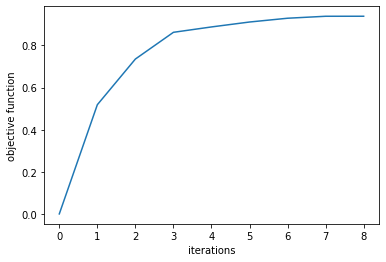

In [15]:
plt.plot(Js)
plt.xlabel('iterations')
plt.ylabel('objective function')
plt.show()

In [16]:
print(f'Initial power conversion = {Js[0]*100:.2f} %')
print(f'Final power conversion = {Js[-1]*100:.2f} %')

Initial power conversion = 0.10 %
Final power conversion = 93.79 %


We then will visualize the final structure, so we convert it to a regular `Simulation` using the final permittivity values and plot it.

In [17]:
sim_final = make_sim(perms_after)

[16:54:59] WARNING  'BoundarySpec.z' uses default value, which is             ]8;id=861505;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=678087;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/boundary.py#607\607]8;;\
                    'Periodic()' but will change to 'PML()' in Tidy3D version                
                    2.0. We recommend explicitly setting all boundary                        
                    conditions ahead of this release to avoid unexpected                     
                    results.                                                                 

<AxesSubplot: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

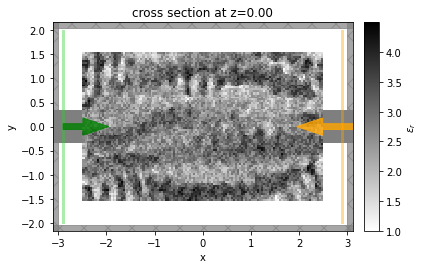

In [18]:
sim_final = sim_final.to_simulation()[0]
sim_final.plot_eps(z=0)

Finally, we want to inspect the fields, so we add a field monitor to the `Simulation` and perform one more run to record the field values for plotting.

In [19]:
field_mnt = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name='field_mnt',
)

sim_final = sim_final.copy(update=dict(monitors=(field_mnt,)))

In [20]:
sim_data_final = web.run(sim_final, task_name='inv_des_final')

[16:55:00] INFO     Created task 'inv_des_final' with task_id                   ]8;id=814127;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=308243;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '72d9f5e0-b87c-48a6-ab9b-489d1a3ab9a5'.                                  

Output()

Output()

[16:55:01] INFO     status = queued                                             ]8;id=352850;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=175737;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[16:55:04] INFO     Maximum FlexUnit cost: 0.025                                ]8;id=53732;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=750354;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[16:55:06] INFO     status = preprocess                                         ]8;id=567490;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=963764;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[16:55:09] INFO     starting up solver                                          ]8;id=172208;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=159569;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[16:55:17] INFO     running solver                                              ]8;id=973913;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=156696;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

Output()

[16:55:18] INFO     status = postprocess                                        ]8;id=762756;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=193832;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:55:25] INFO     status = success                                            ]8;id=535290;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=986567;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[16:55:26] INFO     Billed FlexUnit cost: 0.000                                 ]8;id=240690;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=783190;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=724128;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=227643;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#593\593]8;;\
                    "simulation_data.hdf5"                                                   

Output()

[16:55:27] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=751628;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=704456;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#415\415]8;;\

           WARNING  Simulation final field decay value of 9.25e-07 is greater   ]8;id=316260;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=740860;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#421\421]8;;\
                    than the simulation shutoff threshold of 1e-08. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

We notice that the behavior is as expected and the device performs exactly how we intended!

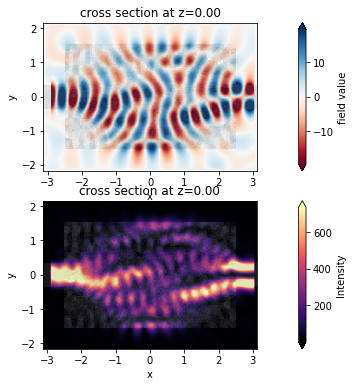

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))
ax1 = sim_data_final.plot_field('field_mnt', 'Ez', z=0, ax=ax1)
ax2 = sim_data_final.plot_field('field_mnt', 'int', z=0, ax=ax2)